In this notebook, we apply GMM-MI to estimate the mutual information between physical parameters and latent variables of the $\beta$-VAE model trained on stellar spectra in [Sedaghat et al. (2021)](https://academic.oup.com/mnras/article-abstract/501/4/6026/6121645?redirectedFrom=fulltext&login=false). We compare our estimates with their results, obtained with histograms as density estimators. The most meaningful latents are found using the median absolute deviation (MAD). All data can be obtained from the [corresponding repository](https://github.com/NimSed/astro-machines).

For this notebook, you will also need `pandas` and `astropy`; you can quickly run form your terminal:
    
    pip install pandas==1.3.4
    pip install astropy

### Import packages

In [1]:
import numpy as np
import os
import pandas as pd
from astropy.stats import sigma_clip
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.utils.plotting import create_heatmap, annotate_heatmap

### Load the data

In [2]:
# latents with highest MAD
significant_dimensions = [11, 19, 58, 85, 99, 124]
stellar_params = ['radvel','Teff','Mass','[M/H]','airmass','snr']

# these steps are taken from the astro-machines repository
codes_file = './astro_machines_data/encoded_harps_unique_128d_e182_i1500000.npy'
codes = pd.DataFrame(np.load(codes_file))
labels = pd.read_csv('./astro_machines_data/harps_metadata_and_labels.csv')

# if looking at the 'unique' subset, drop unnecessary rows
if "unique" in codes_file:
    labels.dropna(subset=['unique_subset'], inplace=True)

# and reindex the codes dataframe accordingly
codes.loc[:,'dp_id'] = labels['dp_id'].values
labels = labels.set_index('dp_id')
codes = codes.set_index('dp_id')

### Calculate MI between significant latents and stellar spectra parameters

In [3]:
# parameters for the deep learning applications, notebooks 9-11
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
# we need to slightly increase reg_covar to avoid
# a singularity in very few occasions... the increase is minimal
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-13)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=5,
                                                       n_folds=3)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e5)

In [4]:
results_file = f'./results/MI_stellar_spectra.npy'

if os.path.isfile(results_file) :
    print('Not running this cell, since results file already exists. '
          'Loading pre-computed results...')
    all_MI_estimates = np.load(results_file)
else:
    print(f'Estimating MI, and saving results...')
    all_MI_estimates = np.zeros((len(stellar_params), len(significant_dimensions), 2))
   
    for li, stellar_param in enumerate(stellar_params):
        label = labels.loc[:, stellar_param].values
        ind_mask = ~np.isnan(label)
        clipped_label = sigma_clip(label,sigma=5,masked=True)
        ind_mask = ind_mask & (~clipped_label.mask)
        stellar_samples = clipped_label.data[ind_mask]    

        for zi, latent_id in enumerate(significant_dimensions):
            significant_latent = codes.iloc[:, latent_id].values
            latent = significant_latent[ind_mask]
            X = np.stack((stellar_samples, latent), axis=0).T          
            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params,
                                      mi_dist_params=mi_dist_params)
            MI_mean, MI_std = mi_estimator.fit(X)   
           
            # store results
            all_MI_estimates[li, zi, 0] = MI_mean
            all_MI_estimates[li, zi, 1] = MI_std

            np.save(results_file, all_MI_estimates)

Not running this cell, since results file already exists. Loading pre-computed results...


### Plot results

In [5]:
y_labels = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']
x_labels = [f"$z_{{{i}}}$" for i in significant_dimensions]
MI_values = all_MI_estimates[:, :, 0]

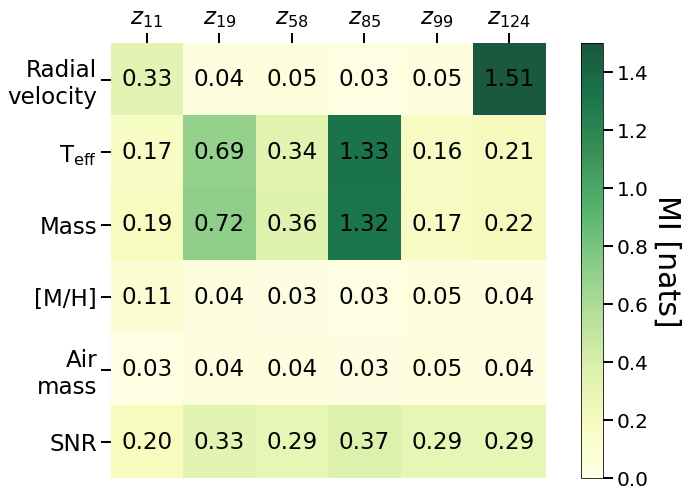

In [6]:
# and plot
im, cbar = create_heatmap(MI_values, y_labels, x_labels, cmap="YlGn", 
                          cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, 
                          vmin=0, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", save_fig=True, 
                         save_path='./figures/Sedaghat_MI_1.pdf',
                         fontsize=23)

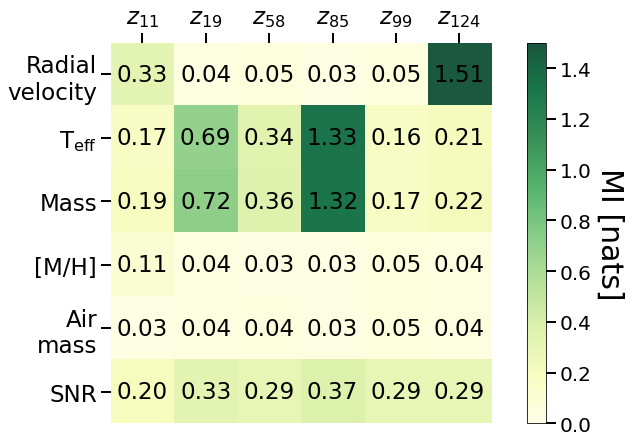

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(24, 7))
im, cbar = create_heatmap(MI_values, y_labels, x_labels, cmap="YlGn", 
                          cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, 
                          vmin=0, fsize=23, ax=ax)
texts = annotate_heatmap(im, valfmt="{x:.2f}", save_fig=True, 
                         save_path='./figures/Sedaghat_MI_1_NeurIPS.pdf',
                         fontsize=23)

### Compare to MI values using histograms, as in Sedaghat et al. (2021)
The following code is obtained and adapted from the [astro-machines repository](https://github.com/NimSed/astro-machines).

In [7]:
#--- A simple joint Probability Density Estimator
def pde2(d1,d2,nbins = 10, sigma=0):
    if sigma > 0:
        d1 = sigma_clip(d1,sigma=sigma)
        d2 = sigma_clip(d2,sigma=sigma)
        
    h,_,_ = np.histogram2d(d1,d2,bins=[nbins,nbins])
    h = h / np.sum(h)
    return h

#----------------------------------------------------------------------------
# Mutual information for joint histogram
# from https://matthew-brett.github.io/teaching/mutual_information.html
#----------------------------------------------------------------------------
def mutual_information(hgram): 
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

nDimensions = codes.shape[1]

sed_MI = np.zeros((len(significant_dimensions), nDimensions))
for k, stellar_param in enumerate(['radvel','Teff','Mass','[M/H]','airmass','snr']):
    label = labels.loc[:,stellar_param].values
    
    #-- Drop NaNs in labels
    ind_mask = ~np.isnan(label)

    #-- Ignore outlier (most probably erroneous) labels
    label_ = sigma_clip(label,sigma=5,masked=True)
    ind_mask = ind_mask & (~label_.mask)
    label_ = label_.data[ind_mask]
    print(f'# of labels: {len(label_)}')

    #--- Compute the MI indicator with 40 bins
    nbinss = [40]
    MI = np.zeros(nDimensions)
    MIs = np.zeros([len(nbinss),nDimensions])

    for b, nbins in enumerate(nbinss):
        for i in range(nDimensions):
            codes_ = codes.iloc[:,i].values
            codes_ = codes_[ind_mask]
            pqk = pde2(codes_,label_,nbins)
            MI[i] = mutual_information(pqk)
            MIs[b,i] = MI[i]
            sed_MI[k, i] = MI[i] 

# only keep significante ones            
sed_MI = sed_MI[:, significant_dimensions]

# of labels: 4090
# of labels: 4293


# of labels: 3351
# of labels: 1932
# of labels: 7007
# of labels: 6988


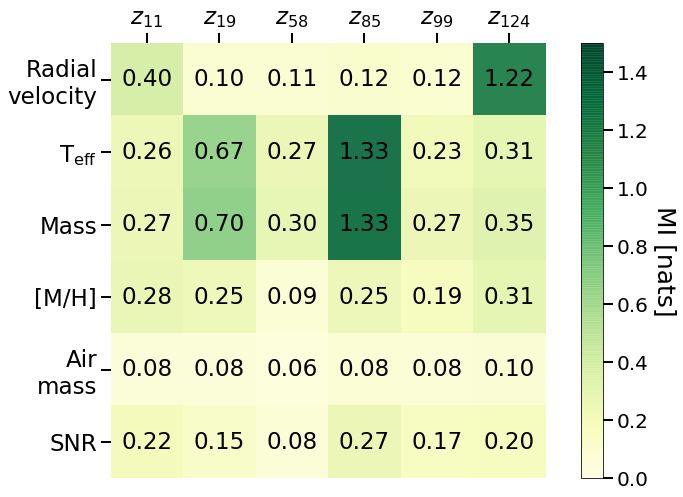

In [8]:
# and plot
im, cbar = create_heatmap(sed_MI, y_labels, x_labels, cmap="YlGn", 
                          cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, 
                          vmin=0, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", save_fig=True, 
                         save_path='./figures/Sedaghat_MI_2.pdf',
                         fontsize=23)